<a href="https://colab.research.google.com/github/albararamli/ic/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Initial Contact (IC) detection**

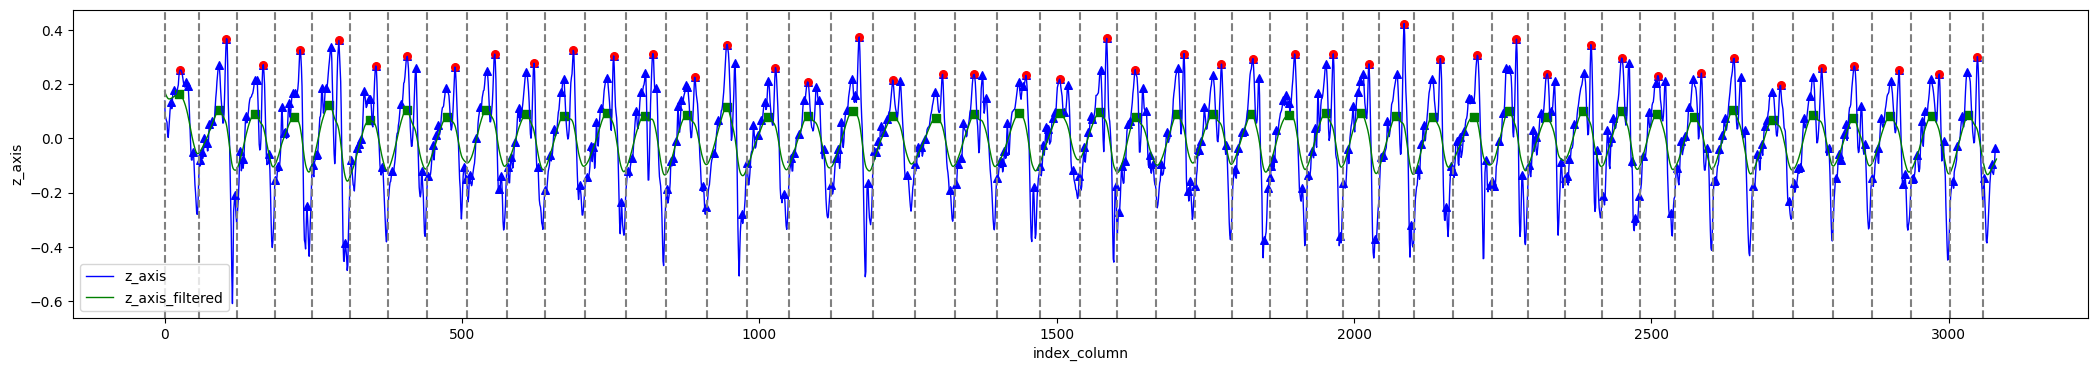

Number of steps = 47


In [1]:
# Initial Contact (IC) detection

import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

# This CSV file serves as an example of accelerometer data. For accurate results, please ensure you are using the file exported from the Walk4me system or refer to the instructions in the accompanying readme file.
DATA_URL = "https://albara.ramli.net/download/xin.liu/dmd/ic/a.csv" 
COLUMNS = ['id','ts_ref','ts_d','ts','x_axis', 'y_axis', 'z_axis']

# Filter and original signal hyperparameters
FILTER_LEVEL_DISTANCE, FILTER_LEVEL_HEIGHT, FILTER_CUTOFF_FREQ = 30, 0.008, 0.029  # filter levels and cutoff frequency
ORI_LEVEL_DISTANCE, ORI_LEVEL_HEIGHT = 1, -1  # original signal levels for distance and height

def download_and_prepare_data(url):
    data = pd.read_csv(url,header=None)
    data.columns = COLUMNS
    data['index_column'] = data.index
    return data

def find_signal_peaks(data, height, distance):
    return signal.find_peaks(data, height=height, distance=distance)[0]

def merge_peaks_with_data(data, peaks):
    peaks_df = pd.DataFrame(peaks, columns=["index_column"])
    return pd.merge(data, peaks_df, on='index_column')

def calculate_border_indices(peaks, data_length):
    border_indices = []
    for i, current_peak in enumerate(peaks):
        next_border = current_peak + round((data_length - 1 - current_peak) / 2) if i == len(peaks) - 1 else current_peak + round((peaks[i+1] - current_peak) / 2)

        if i == 0:  # calculate previous border for the first peak
            previous_border = max(current_peak - round(next_border - current_peak), 0)
            border_indices.append(previous_border)
        
        border_indices.append(next_border)
    return border_indices

def get_ic_indices(border_indices, original_peaks, z_axis_data):
    ic_indices = []
    for i in range(1, len(border_indices)):
        current_border, previous_border = border_indices[i], border_indices[i-1]
        max_peak_val, max_peak_index = float('-inf'), float('-inf')
        for peak in original_peaks:
            if previous_border < peak <= current_border:
                if max_peak_val < z_axis_data[peak]:
                    max_peak_val, max_peak_index = z_axis_data[peak], peak
        if max_peak_index != float('-inf'):
            ic_indices.append(max_peak_index)
    return ic_indices

def plot_data(data,data_with_ori_peaks, data_with_filtered_peaks, data_with_ic, border_indices):
    fig, ax = plt.subplots(figsize=(26, 4))

    # Draw original signal and its peaks
    data.plot(ax=ax, x="index_column", y="z_axis", color="Blue", lw='1')
    data_with_ori_peaks.plot.scatter(ax=ax, x="index_column", y="z_axis", color='Blue', s=30, marker='^')

    # Draw filtered signal and its peaks
    data.plot(ax=ax, x="index_column", y="z_axis_filtered", color="Green", lw='1')
    data_with_filtered_peaks.plot.scatter(ax=ax, x="index_column", y="z_axis_filtered", color='Green', s=30, marker='s')

    # Draw borders
    for border_x in border_indices:
        ax.axvline(border_x, color="Gray", linestyle="dashed")

    # Draw IC
    data_with_ic.plot.scatter(ax=ax, x="index_column", y="z_axis", color='Red', s=30, marker='o')

    # Display and close figure
    plt.show()
    plt.close()

def main():
    data = download_and_prepare_data(DATA_URL)

    N, Wn = 1, FILTER_CUTOFF_FREQ
    B, A = signal.butter(N, Wn, btype='lowpass', output='ba')
    filtered_signal = signal.filtfilt(B, A, data['z_axis'])

    filtered_signal_peaks = find_signal_peaks(filtered_signal, FILTER_LEVEL_HEIGHT, FILTER_LEVEL_DISTANCE)
    ori_signal_peaks = find_signal_peaks(data['z_axis'], ORI_LEVEL_HEIGHT, ORI_LEVEL_DISTANCE)

    data["z_axis_filtered"] = pd.DataFrame(filtered_signal)
    data_with_ori_peaks = merge_peaks_with_data(data, ori_signal_peaks)
    data_with_filtered_peaks = merge_peaks_with_data(data, filtered_signal_peaks)

    border_indices = calculate_border_indices(filtered_signal_peaks, len(data['z_axis']))

    ic_indices = get_ic_indices(border_indices, ori_signal_peaks, data['z_axis'])

    data_with_ic = merge_peaks_with_data(data, ic_indices)

    plot_data(data,data_with_ori_peaks, data_with_filtered_peaks, data_with_ic, border_indices)

    # Print the number of steps
    print("Number of steps =", data_with_ic.shape[0])

if __name__ == "__main__":
    main()